 # Bandpass caliberation of Ettus x300 at low frequencies which ended up mainly being a catalog of spurious signals internal to the radio

### By Danny Jacobs
##### 17 Aug 2018

In [109]:
%matplotlib notebook
from matplotlib.pyplot import *
import numpy as np
def dB(x):
    return 10*np.log10(x)
#from scipy.signal import savgol_filter

In [119]:
D = np.load('tuning_scan_waterfall_24July2018_1457.npz')#load 1MHz steps
#D = np.load('tuning_scan_waterfall_24July2018_1611.npz')#antenna 5MHz steps
#D = np.load('tuning_scan_waterfall_24July2018_1615.npz')#load 5MHz steps
D = np.load('tuning_scan_waterfall_30July2018_1336.npz')# longer integration


['df', 'FFT_size', 'B', 'data', 'tunings']


In [120]:
sample_rate = 200e6 #copied from spectrum.py
df = sample_rate/D['FFT_size']
print(614*df)/1e6


59.9609375


<IPython.core.display.Javascript object>


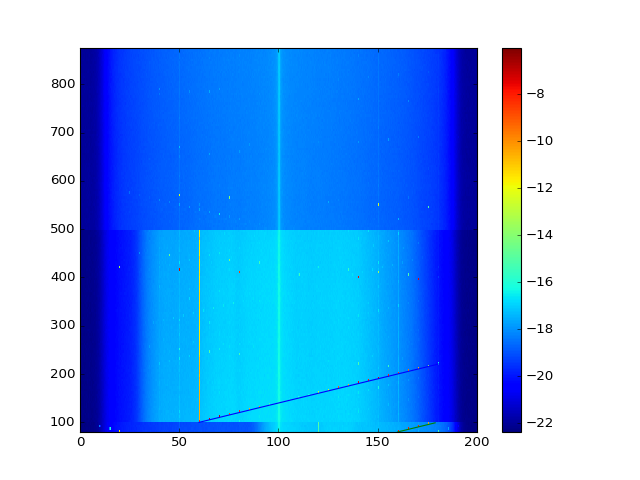

80000000.0


(80.0, 875.0)

In [121]:
figure()
imshow(10*np.log10(D['data'][2][::-1,:]),aspect='auto',interpolation='nearest',
       extent=(0,D['FFT_size']*df/1e6,D['tunings'].min()/1e6,D['tunings'].max()/1e6))
plot()
colorbar()
print D['tunings'].min()
f1=np.arange(100,222)
b1 = f1-40
plot(b1,f1)
f2=np.arange(80,100)
b2=f2+80
plot(b2,f2)

ylim([D['tunings'].min()/1e6,D['tunings'].max()/1e6])

<IPython.core.display.Javascript object>


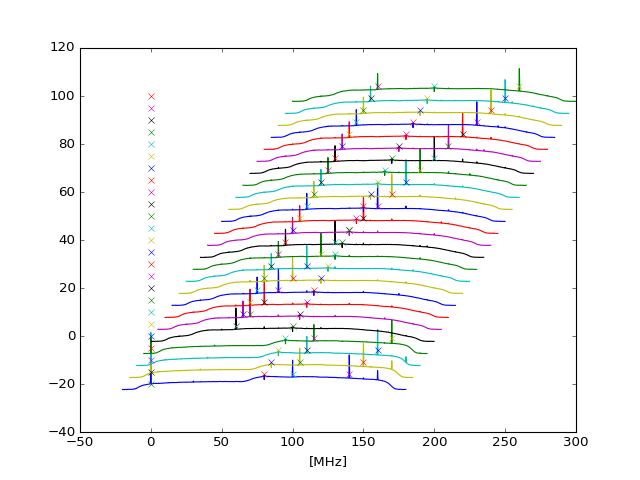

In [158]:
def B1(tuning):
   return 0
def B2(tuning):
    return tuning
def B3(tuning):
    #in the >100MHz tunings the baseband has a 60MHz tone
    #not sure why the tunings all have 100MHz added 
    # output of mixer: f_lo+f_s and f_lo-f_s
    #   suppose f_lo has a f_lo+60MHz tone, also suppose that f_s gets some f_lo in it,
    #   then we'll also get f=60MHz and 2f_lo+60MHz
    if tuning>99e6:
        return tuning- 100e6 + 60e6 
    else: return None
def B4(tuning):
    #theres also a factor of 2
    if tuning >99e6:
        return 2*(tuning-100e6) + 60e6
def B5(tuning):
    if(tuning)<100e6:
        return tuning + 20e6
def B6(tuning):
    if tuning < 100e6:
        return 2*tuning-20e6    
def B7(tuning):
    return 2*tuning
figure()
Lfreqs = np.arange(0,D['FFT_size'])*df - D['FFT_size']*df/2
for i in range(25):
    freqs = Lfreqs + D['tunings'][i]
    plot(freqs/1e6,dB(D['data'][2,i])+5*i)
    b1 = B1(D['tunings'][i])
    if b1 is not None: plot(b1/1e6,5*i-20,'x')#DC mode
    b2 = B2(D['tunings'][i])
    if b2 is not None:plot(b2/1e6,5*i-16,'x')#LO DC mode
    b3 = B3(D['tunings'][i])
    if b3 is not None: plot(b3/1e6,5*i-16,'x')#60MHz 
    b4 = B4(D['tunings'][i])
    if b4 is not None: plot(b4/1e6,5*i-16,'x')#60MHz LO leakage?
    b5 = B5(D['tunings'][i])
    if b5 is not None: plot(b5/1e6,5*i-16,'x')
    b6 = B6(D['tunings'][i])
    if b6 is not None: plot(b6/1e6,5*i-16,'x')
    #print b6
    #b7 = B7(D['tunings'][i])
    #if b7 is not None: plot(b7/1e6,5*i-16,'x')
xlabel('[MHz]')





(-5.0, 4.9900000000000002)


<IPython.core.display.Javascript object>


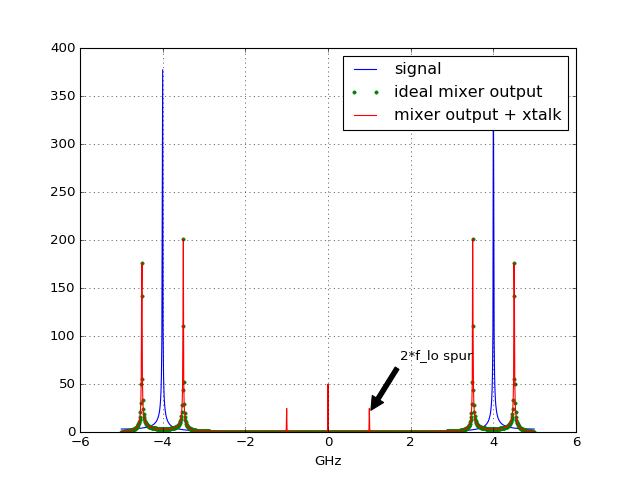

In [208]:
#A model for how we can get tones at 2x the mixer frequency
# leakage of the LO into the signal path before the mixer

f = 4 #signal freq in GHz
dt = 0.1# sample time in ns
DT = 100 #sample window length 100 ns
t = np.linspace(0,DT,num=DT/dt)#time in ns
s = np.sin(2*np.pi*t*f)
f_lo = 0.5 #LO in GHz
s_lo = np.sin(2*np.pi*t*f_lo)  #local oscillator signal

freqs = np.fft.fftshift(np.fft.fftfreq(len(t),dt))
print(freqs.min(),freqs.max())
figure()
plot(freqs,np.abs(np.fft.fftshift(np.fft.fft(s))),label='signal')
s_m = s_lo*s
plot(freqs,np.abs(np.fft.fftshift(np.fft.fft(s_m))),'.',label='ideal mixer output')
s_m = s_lo*(s+0.1*s_lo)
plot(freqs,np.abs(np.fft.fftshift(np.fft.fft(s_m))),label='mixer output + xtalk')
#axvline(2*f_lo)
#axvline(-2*f_lo)
annotate('2*f_lo spur',(2*f_lo,20),(1.75,75),arrowprops=dict(facecolor='black', shrink=0.05))
xlabel('GHz')
legend()
grid()

In [165]:
def tone_flag(tuning):
    #input a tunning in Hz, output a list of frequencies to flag
    flag_freqs = [0,tuning]
    #in the >100MHz tunings the baseband has a 60MHz tone
    #not sure why the tunings all have 100MHz added 
    # output of mixer: f_lo+f_s and f_lo-f_s
    #   suppose f_lo has a f_lo+60MHz tone, also suppose that f_s gets some f_lo in it,
    #   then we'll also get f=60MHz and 2f_lo+60MHz
    if tuning>99e6:
        flag_freqs.append(tuning- 100e6 + 60e6)
    if tuning >99e6:
        flag_freqs.append(2*(tuning-100e6) + 60e6)
    if tuning >99e6:
        flag_freqs.append(2*tuning-100e6 + 20e6)
    if tuning >99e6:
        flag_freqs.append(tuning + 60e6)
    if tuning > 99e6:
        flag_freqs.append(2*tuning - 100e6 - 20e6)
    if tuning > 99e6:
        flag_freqs.append(tuning + 50e6)
    if tuning > 99e6:
        flag_freqs.append(tuning + 10e6)
    if tuning > 99e6:
        flag_freqs.append(tuning - 10e6)
    if(tuning)<100e6:
        flag_freqs.append(tuning + 20e6)
    if tuning < 100e6:
        flag_freqs.append(2*tuning-20e6)   
    flag_freqs.append(tuning - 50e6)
    flag_freqs.append(2*tuning)
    return np.array(flag_freqs)
def grow_flags(flags,n):
    #grow each flagged area such that single flags expands by width n
    # eg input flags  = [0, 0 ,0 ,0,1,0,0,0,0] and n = 3
    # returns [0,0,0,0,1,1,1,0,0,0]
    w = np.ones(n)
    c = np.convolve(flags,w,mode='same')
    return np.where(c!=0,1,0)
def mask_ettus(spectrum,tuning,flag_width=7):
    flag_freqs = tone_flag(tuning)
    I = np.digitize(flag_freqs,freqs)
    I = I[I<len(freqs)]
    mask = np.zeros_like(spectrum)
    mask[I] = 1
    mask = grow_flags(mask,flag_width)
    mask[:100] =1 #flag the edges of the band
    mask[-100:] = 1
    spectrum = np.ma.masked_where(mask,spectrum)    
    return spectrum

<IPython.core.display.Javascript object>


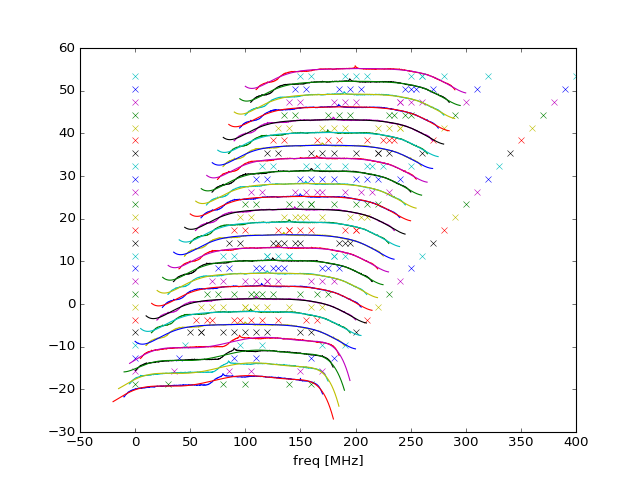

In [186]:
#flag out channels with LO-like things in them
figure()
Lfreqs = np.arange(0,D['FFT_size'])*df - D['FFT_size']*df/2
mask = np.zeros(D['FFT_size'])
offset = 3
for i in range(25):

    freqs = Lfreqs + D['tunings'][i]
#    mask *=0
#     flag_freqs = tone_flag(D['tunings'][i])
#     I = np.digitize(flag_freqs,freqs)
#     I = I[I<len(freqs)]
#     mask[I] = 1
#     mask = grow_flags(mask,7)
#     mask[:100] =1 #flag the edges of the band
#     mask[-100:] = 1
#    spectrum = np.ma.masked_where(mask,D['data'][2,i])
    spectrum = mask_ettus(D['data'][2,i],D['tunings'][i])
    plot(freqs/1e6,dB(spectrum)+offset*i)
    #plot flag locations
    flag_freqs = tone_flag(D['tunings'][i])
    plot(flag_freqs/1e6,np.ones_like(flag_freqs)*offset*i+np.mean(dB(D['data'][2,0])),'x')
    
    #fit a polynomial
    bp_fit = np.ma.polyfit(Lfreqs,dB(spectrum),8)
    bp_model = np.poly1d(bp_fit)(Lfreqs)
    bp_model = np.ma.masked_where(mask,bp_model)
    plot(freqs/1e6,bp_model+offset*i,'-')
xlabel('freq [MHz]')
    #fit a sg 
    #bp_model_sg = savgol_filter(dB(spectrum),11,4)
    #plot(freqs/1e6,bp_model_sg+5*i)

<IPython.core.display.Javascript object>


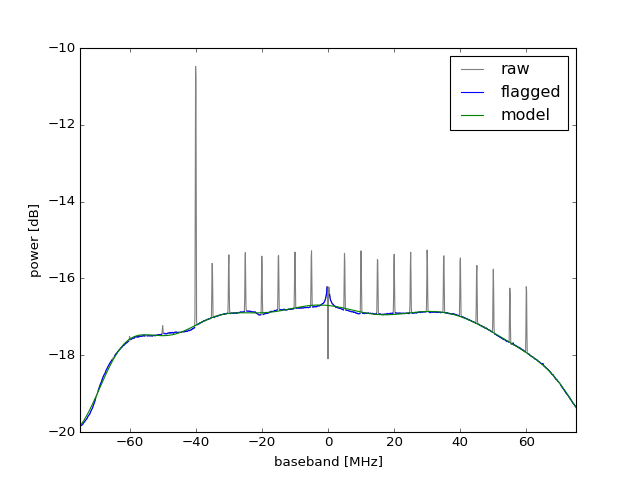

/home/raobs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/home/raobs/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [202]:
#build a bp model
avg_spectrum = np.zeros(D['FFT_size'])
avg_spectrum_flagged = np.ma.zeros(D['FFT_size'])
n = 0
for i in xrange(25):
    if D['tunings'][i]<100e6:continue #something is very weird when we tuning below 100MHZ
    
    avg_spectrum += D['data'][2,i]
    flagged_spectrum = mask_ettus(D['data'][2,i],D['tunings'][i]) #lets flag those baddies\
    avg_spectrum_flagged += flagged_spectrum
    n += 1
avg_spectrum /= n
avg_spectrum_flagged /= n
figure()
plot(Lfreqs/1e6,dB(avg_spectrum),'0.5',label='raw')
plot(Lfreqs/1e6,dB(avg_spectrum_flagged),label='flagged')
#fit a polynomial
bp_fit = np.ma.polyfit(Lfreqs,dB(avg_spectrum_flagged),25)
bp_model = np.poly1d(bp_fit)(Lfreqs)
plot(Lfreqs/1e6,bp_model,label='model')
xlim(-75,75)
ylim(-20,-10)
xlabel('baseband [MHz]')
ylabel('power [dB]')
legend()